# Lab 4: Non-negative Matrix Factorization

Welcome to the advanced Machine Learning Course.

The objective of this lab session is to code a few regression algorithms and to apply them to synthetic and real datasets.

Please put **"ML - MDS - TD4"** in the mail subject or I might lose your work (which means 0) and send it to pierre.houdouin@centralesupelec.fr

Please label your notebook **"L4_familyname1_familyname2.ipynb"** or I might lose your work (which means 0).

We begin with the standard imports:

In [14]:
import numpy             as np
import matplotlib.pyplot as plt
import seaborn           as sns
from sklearn.utils       import check_random_state
from sklearn.datasets    import fetch_olivetti_faces
from tqdm import tqdm

%matplotlib inline
sns.set_context('poster')
sns.set_color_codes()
plot_kwds        = {'alpha' : 0.25, 's' : 80, 'linewidths':0}

dataset          = fetch_olivetti_faces(shuffle=True)
faces            = dataset.data.T #on représente chaque image par une colonne, en accord avec le cours
faces[3523][338] = 1e-2 #l'un des éléments de faces est nul, ce qui bloque la divergence de KL

## NMF

Loss (Regularized Froebnius): $\mathcal{L}(W, H) = \frac{1}{2}\|X-W H\|_{F}^{2}+ {\frac{\mu}{2}\|H\|_{F}^{2}+\lambda\|H\|_{1}+\frac{\nu}{2}\|W\|_{F}^{2}}$

Algorithm (multiplicative updates from [Lee and Seung, 1999]: 

\begin{array}{c}
W \leftarrow W \circ \frac{X H^{\top}}{W (H H^{\top} + { \nu I_r})} \\
H \leftarrow H \circ \frac{W^{\top} X - { \lambda 1_{r \times n}}}{(W^{\top} W + { \mu I_r})H}
\end{array}

Fill in the following NMF class:

In [15]:
class MYNMF():
    
    """ Class for logistic regression:
    
    Attributes:                                                                                 
    -----------                                                Default value
    n_components_ : integer,  unknown dimension of W and H   | 20                
    max_iter_     : integer,  maximum number of iterations   | 60
    epsilon_      : float,    epsilon coefficient            | 1e-4
    loss_         : str,      {"Frobenius", "KL"}            | Frobenius
    D_            : np.array, W Matrix factor                | None
    S_            : np.array, H Matrix factor                | None
    D_history     : list,     W Matrix history               | []
    S_history     : list,     H Matrix history               | []
    loss_history  : list,     history of loss                | []
    random_state  : int,      for the random initialization  | 42
    """
    
    def __init__(self, n_components=20, max_iter=200, epsilon = 1e-5, loss = "Frobenius", random_state=42):
        
        self.n_components_ = n_components
        self.max_iter_     = max_iter
        self.epsilon_      = epsilon
        self.loss_         = loss
        self.D_            = None
        self.S_            = None
        self.D_history     = []
        self.S_history     = []
        self.loss_history  = []
        self.random_state  = random_state
        self.components_   = None    # shape (r, p)
        
    def fit_transform(self, data, mu=5e-3,  nu=5e-3, lambd=1e-3):
        
        """ Find the factor matrices D and S for matrix factorization of data
        
        Parameters:
        -----------                                 Default value       
        data  : (p, n) np.arrayData, matrix       | 
        mu    : float, regularization parameter   | 5e-3
        lambd : float, regularization parameter   | 1e-3
        nu    : float, regularization parameter   | 5e-3
        
        Returns:
        -----
        embedding: (p, r) np.array
                    Embedding matrix        
        """        
        p, n    = data.shape # rows, cols
        
        self.D_ = np.abs( np.random.random(( p, self.n_components_))) # W
        self.S_ = np.abs( np.random.random(( self.n_components_, n))) # H
        
        self.loss_history = []
        
        def Frobenius(data, D, S):
            """Computes the Frobenius norm-based loss between dataset and the facto W @ H """
            
            DS = np.dot( D, S )
            reconstruction_error  = np.linalg.norm( data - DS, 'fro') ** 2 
            mu_reg_H = mu / 2 * np.linalg.norm(S, 'fro') ** 2
            nu_reg_D = nu / 2 * np.linalg.norm(D, 'fro') ** 2
            lambd_pen = lambd * np.linalg.norm( S, ord=1 )
            
            return reconstruction_error + mu_reg_H + nu_reg_D + lambd_pen 
        
        def KL_divergence(data, D, S):
            """Computes the Kullback-Leibler divergence between dataset and the facto W @ H """
            
            DS = np.dot( D, S )
            reconstruction_error = data * np.log( data / DS ) + DS - data
            
            return np.sum( reconstruction_error )
        
        if self.loss_ == "Frobenius":
            
            # Initialization
            dist = Frobenius( data, self.D_, self.S_ )
            
            for i in range( self.max_iter_ ):
                
                DS = np.dot(self.D_,self.S_)
            
                # W algorithm
                self.D_ = self.D_ * ( np.dot( data, self.S_.T )) / (
                    np.dot( self.D_, np.dot( self.S_, self.S_.T ) + nu ) + self.epsilon_ )
                
                # H algorithm
                self.S_ = self.S_ * ( np.dot( self.D_.T, data) - lambd )/(
                    np.dot( np.dot( self.D_.T, self.D_ ) + mu, self.S_ + self.epsilon_ ))
                
                # Iterations on the frobinius norm-based loss
                dist = Frobenius( data, self.D_, self.S_ )
                
                # History for tracking the minimal value to get the optimal
                self.S_history.append(self.S_)
                self.D_history.append(self.D_)
                self.loss_history.append(dist)
        
        elif self.loss_ == "KL":
            
            # Initialisation
            dist = KL_divergence( data, self.D_, self.S_ )
            
            for i in range( self.max_iter_ ):
                
                DS = np.dot( self.D_, self.S_ )
                D  = self.D_
                S  = self.S_
                
                for i in range( p ):
                    for j in range( self.n_components_ ):
                        
                        # Algorithm
                        D[i][j] = D[i][j] * np.sum( data[i] * S[j] / DS[i]) / ( np.sum( S[j] ) + self.epsilon_)
        
                DS = np.dot( self.D_, self.S_ )
            
                for i in range( self.n_components_ ):
                    for j in range( n ):
                        
                        # Algorithm
                        S[i][j] = S[i][j] * np.sum(data.T[j] * D.T[i] / DS.T[j] ) / ( np.sum( D.T[i] ) + self.epsilon_)
                
                # Iterations on the divergence
                dist = KL_divergence(data,self.D_,self.S_)
                
                # History for tracking the minimal value to get the optimal
                self.S_history.append(self.S_)
                self.D_history.append(self.D_)
                self.loss_history.append(dist)
                
        return self.S_.T

        
    def predict_label(self, X):
        """ Predict labels for X : cluster hard-assignment
        
        Parameters:
        -----------
        X: (n, p) np.array, data matrix
        
        Returns:
        -----
        label assignment : (p, ) np.array, Its elements are the predicted classes, from 0 to r-1
        
        """
        labels = np.argmax( self.S_, axis=0)
        
        return labels
        
    def predict_proba(self, X):
        """ Predict probabilities of different classes for X :  cluster soft-assignment
        
        Parameters:
        -----------
        X: (n, p) np.array
            New data matrix
        
        Returns:
        -----
        label_assignment : (n, r) np.array
                          Its elements are the probabilities for different classes
        """
        S_sum = self.S_.sum( axis=0, keepdims = True)
        S_normalized = self.S_ / S_sum
        
        return S_normalized.T

## Hyperparameter optimization

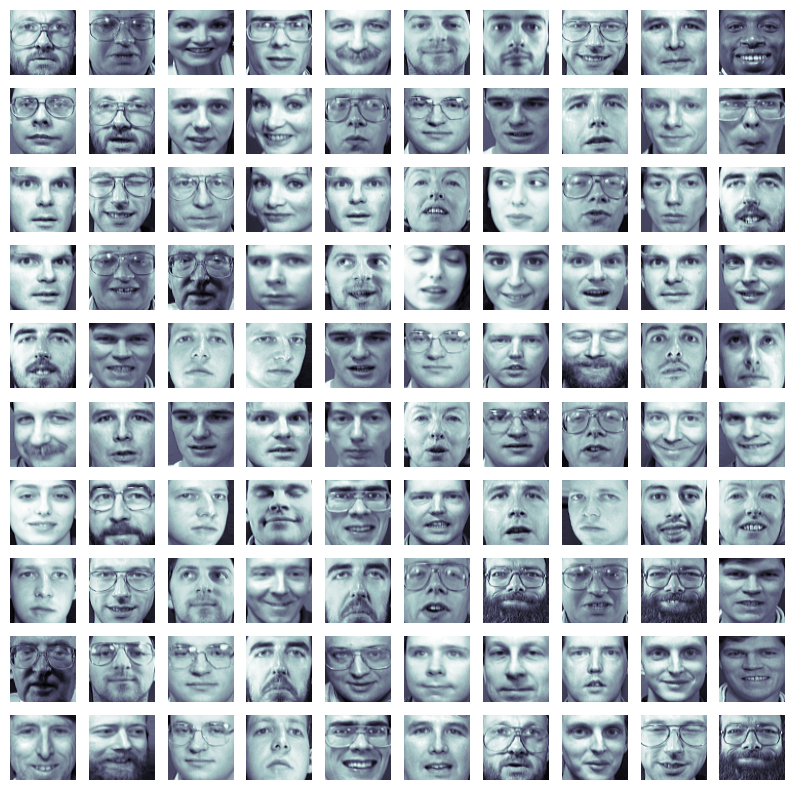

In [16]:
fig, ax = plt.subplots(10, 10, figsize=(10, 10))

for j, axi in enumerate( ax.flat ):
    axi.imshow(dataset.data[j].reshape( 64, 64), cmap='bone')
    axi.axis('off')

### Regularization parameter : mu

In [17]:
#TODO : find best mu

epochs        = 100
components    = 20

loss_function = "Frobenius"

mu_loss       = []
mus           = [1e-4,5e-4,1e-3,5e-3,1e-2,5e-2,1e-1,5e-1,1,5,10,50]

for mu in tqdm( mus ):
    
    myNMF = MYNMF(max_iter = epochs, n_components = components, loss = loss_function)
    myNMF.fit_transform(faces, mu = mu, nu = 1, lambd = 1)
    mu_loss.append(min(myNMF.loss_history))


100%|██████████| 12/12 [01:28<00:00,  7.41s/it]


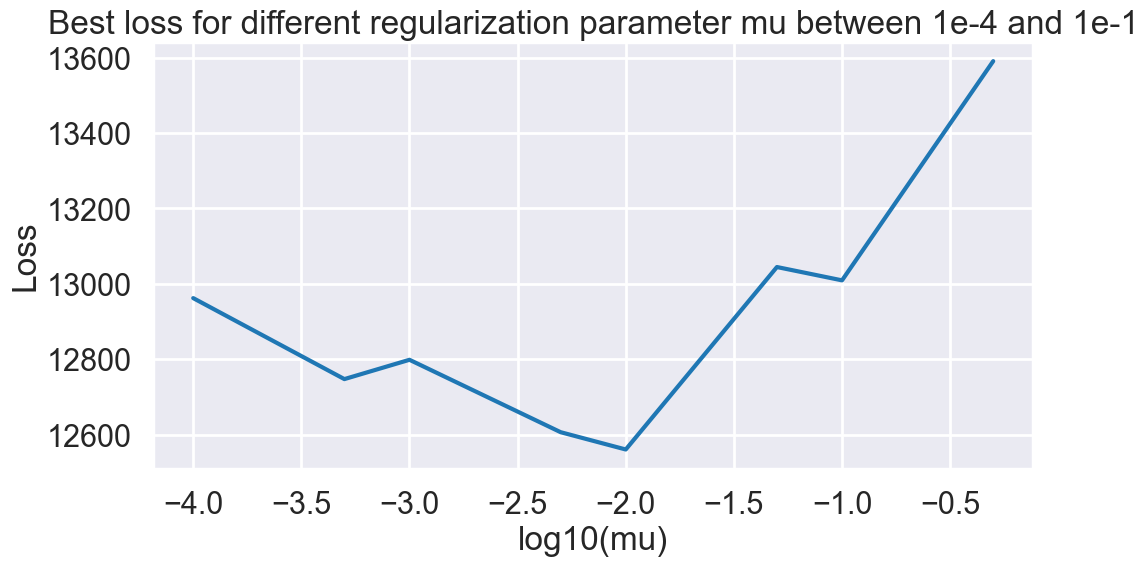

In [18]:
plt.title("Best loss for different regularization parameter mu between 1e-4 and 1e-1")
plt.subplots_adjust(right = 1.5, top = 1)
plt.xlabel("log10(mu)")
plt.ylabel("Loss")
plt.plot(np.log(mus[:8])/np.log(10), mu_loss[:8])
plt.show()

### Interpration : the best value for mu is -3.00 in log10 which is equal to 0.001

### Regularization parameter : nu

In [19]:
#TODO : find best nu

epochs        = 100
r             = 20
loss_function = "Frobenius"

nu_loss       = []
nus           = [1e-4,5e-4,1e-3,5e-3,1e-2,5e-2,1e-1,5e-1,1,5,10,50]

for Nu in tqdm( nus ):
    
    myNMF = MYNMF(max_iter = epochs, n_components = r, loss = loss_function)
    myNMF.fit_transform(faces, mu = 5e-2, nu = Nu, lambd = 1)
    nu_loss.append(min(myNMF.loss_history))

100%|██████████| 12/12 [01:27<00:00,  7.32s/it]


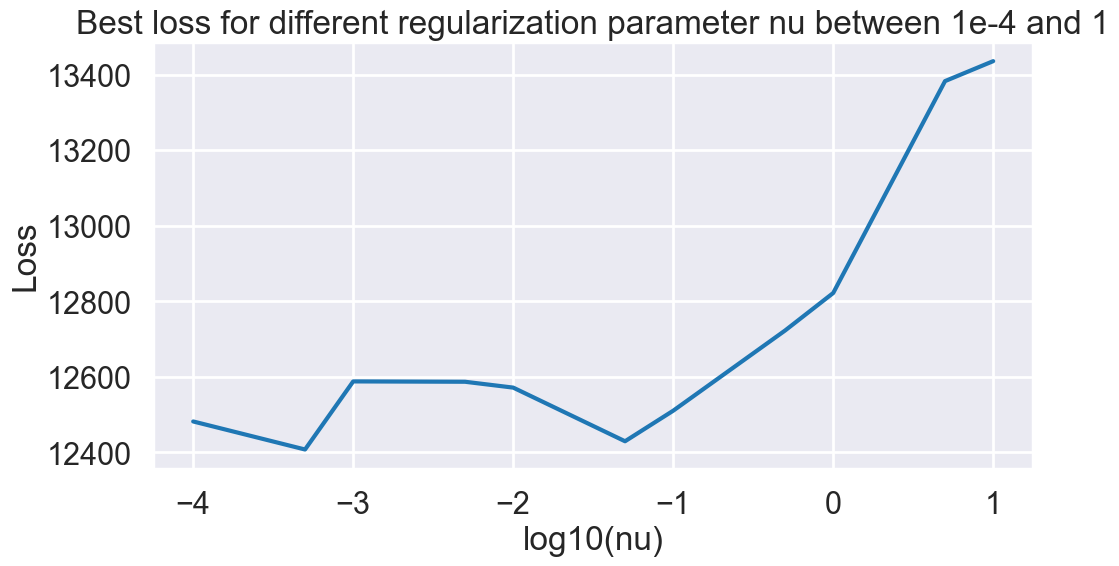

In [20]:
plt.title("Best loss for different regularization parameter nu between 1e-4 and 1")
plt.subplots_adjust(right = 1.5, top = 1)
plt.xlabel("log10(nu)")
plt.ylabel("Loss")
plt.plot(np.log(nus[:11])/np.log(10), nu_loss[:11])
plt.show()

### Interpration : the best value for nu is -3.0 in log10 which is equal to 5e-4 (we don't want to take an extreme value for border effect

### Regularization parameter : lambda

In [21]:
#TODO : find best lambda

epochs        = 100
r             = 20
loss_function = "Frobenius"

lambda_loss   = []
lambdas       = [1e-4,5e-4,1e-3,5e-3,1e-2,5e-2,1e-1,5e-1,1,5,10,50]

for Lambd in tqdm( nus ):
    
    myNMF = MYNMF(max_iter = epochs, n_components = r, loss = loss_function)
    myNMF.fit_transform(faces, mu = 5e-2, nu = 5e-4, lambd = Lambd)
    lambda_loss.append(min(myNMF.loss_history))

100%|██████████| 12/12 [01:26<00:00,  7.21s/it]


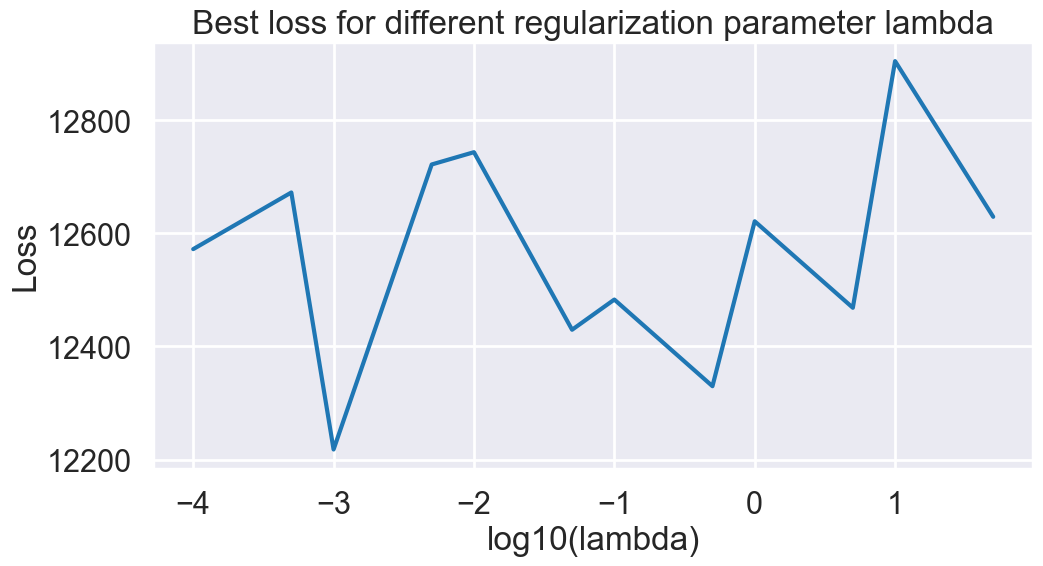

In [22]:
plt.title("Best loss for different regularization parameter lambda")
plt.subplots_adjust(right = 1.5, top = 1)
plt.xlabel("log10(lambda)")
plt.ylabel("Loss")
plt.plot(np.log(lambdas)/np.log(10), lambda_loss)
plt.show()

### Interpration : the best value for lambda is 0 because the other would be undefined.

In [23]:
#TODO : check results for mu, nu and lambda with new obtained regularization parameters

epochs        = 100
r             = 20
loss_function = "Frobenius"

model_loss = []

myNMF.fit_transform(faces, mu = 5e-2, nu = 5e-4, lambd = 0)
model_loss.append(min(myNMF.loss_history))

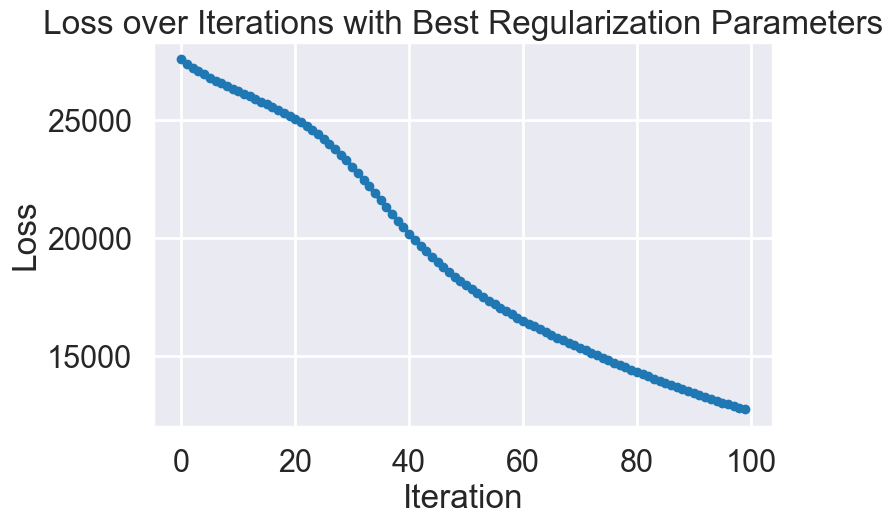

In [24]:
plt.figure(figsize=(8, 5))
plt.plot(myNMF.loss_history, marker='.')
plt.title('Loss over Iterations with Best Regularization Parameters')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

### Interpretation : we can see the loss decreasing through the 100 epochs without any trouble

### Number of components

We are going to determine the **optimal number of components** for the factorization by plotting the final loss after 100 epochs for different number of components.
We expect an **elbow curve**, and we will choose the value at the elbow point. Indeed, the higher the number of components is, the more precise the atoms of the dictionary can be, and thus the more precise the reconstructed image will be.
We will find the optimal parameter both for Frobenius and Kullback-Leibler distances.

#### Case of Frobenius distance

In [25]:
#TODO

epochs         = 100
loss_function  = "Frobenius"

component_loss = []
components     = [ 10 * i for i in range (1,20) ]

for component in tqdm( components ):
    
    myNMF = MYNMF( max_iter = epochs, n_components = component, loss = loss_function)
    myNMF.fit_transform( faces )
    component_loss.append(min( myNMF.loss_history ))

100%|██████████| 19/19 [02:53<00:00,  9.13s/it]


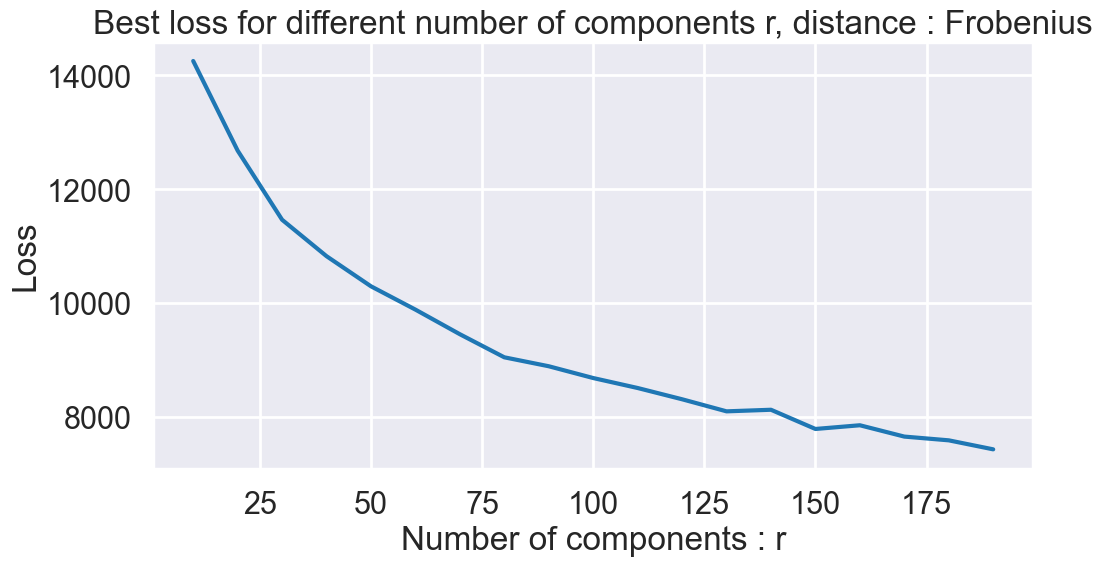

In [26]:
plt.title("Best loss for different number of components r, distance : Frobenius")
plt.subplots_adjust(right = 1.5, top = 1)
plt.xlabel("Number of components : r")
plt.ylabel("Loss")
plt.plot(components, component_loss)
plt.show()

#### Case of Kullback-Leibler divergence

In [ ]:
#TODO

epochs         = 100
loss_function  = "KL"

component_loss = []
components     = [ 10 * i for i in range (1, 10)]

for component in tqdm( components ):
    
    myNMF = MYNMF(max_iter = epochs, n_components = component, loss = loss_function)
    myNMF.fit_transform(faces)
    component_loss.append(min(myNMF.loss_history))

 44%|████▍     | 4/9 [22:04<32:09, 386.00s/it]

In [ ]:
plt.title("Best loss for different number of components r, distance : Kullback-Leibler")
plt.subplots_adjust(right = 1.5, top = 1)
plt.xlabel("Number of components : r")
plt.ylabel("Loss")
plt.plot(components, component_loss)
plt.show()

## Comparison between the two distances

In [ ]:
#TODO : plot the loss and normalized distances between S and D for different number of components
    

## Model training

### Training with Frobenius distance for different number of components

In [ ]:
#TODO : Train different models for different number of components with Frobenius loss and plot loss function 

epochs        = 150
loss_function = "Frobenius"


myNMF_10_Fr  = MYNMF(n_components =  10, max_iter = epochs, loss = loss_function)
myNMF_10_Fr.fit_transform(faces)
myNMF_20_Fr  = MYNMF(n_components =  20, max_iter = epochs, loss = loss_function)
myNMF_20_Fr.fit_transform(faces)
myNMF_25_Fr  = MYNMF(n_components =  25, max_iter = epochs, loss = loss_function)
myNMF_25_Fr.fit_transform(faces)
myNMF_30_Fr  = MYNMF(n_components =  30, max_iter = epochs, loss = loss_function)
myNMF_30_Fr.fit_transform(faces)
myNMF_35_Fr  = MYNMF(n_components =  35, max_iter = epochs, loss = loss_function)
myNMF_35_Fr.fit_transform(faces)
myNMF_70_Fr  = MYNMF(n_components =  70, max_iter = epochs, loss = loss_function)
myNMF_70_Fr.fit_transform(faces)
myNMF_100_Fr = MYNMF(n_components = 100, max_iter = epochs, loss = loss_function)
myNMF_100_Fr.fit_transform(faces)
myNMF_150_Fr = MYNMF(n_components = 150, max_iter = epochs, loss = loss_function)
myNMF_150_Fr.fit_transform(faces)
myNMF_200_Fr = MYNMF(n_components = 200, max_iter = epochs, loss = loss_function)
myNMF_200_Fr.fit_transform(faces)
myNMF_300_Fr = MYNMF(n_components = 300, max_iter = epochs, loss = loss_function)
myNMF_300_Fr.fit_transform(faces)


plt.title("Best loss for different number of components r, distance : Frobenius")
plt.subplots_adjust(right = 3, top = 2)
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.plot(range(epochs), myNMF_10_Fr.loss_history,label  = "Number of component =  10")
plt.plot(range(epochs), myNMF_20_Fr.loss_history,label  = "Number of component =  20")
plt.plot(range(epochs), myNMF_25_Fr.loss_history,label  = "Number of component =  25")
plt.plot(range(epochs), myNMF_30_Fr.loss_history,label  = "Number of component =  30")
plt.plot(range(epochs), myNMF_35_Fr.loss_history,label  = "Number of component =  35")
plt.plot(range(epochs), myNMF_70_Fr.loss_history,label  = "Number of component =  70")
plt.plot(range(epochs), myNMF_100_Fr.loss_history,label = "Number of component = 100")
plt.plot(range(epochs), myNMF_150_Fr.loss_history,label = "Number of component = 150")
plt.plot(range(epochs), myNMF_200_Fr.loss_history,label = "Number of component = 200")
plt.plot(range(epochs), myNMF_300_Fr.loss_history,label = "Number of component = 300")
plt.legend()
plt.show()

### Training with KL-divergence for different number of components

In [ ]:
#TODO : Train different models for different number of components with KL divergence and plot loss function 

epochs        = 150
loss_function = "KL"

myNMF_10_KL  = MYNMF(n_components =  10, max_iter = epochs, loss = loss_function)
myNMF_10_KL.fit_transform(faces)
myNMF_20_KL  = MYNMF(n_components =  20, max_iter = epochs, loss = loss_function)
myNMF_20_KL.fit_transform(faces)
myNMF_25_KL  = MYNMF(n_components =  25, max_iter = epochs, loss = loss_function)
myNMF_25_KL.fit_transform(faces)
myNMF_30_KL  = MYNMF(n_components =  30, max_iter = epochs, loss = loss_function)
myNMF_30_KL.fit_transform(faces)
myNMF_35_KL  = MYNMF(n_components =  35, max_iter = epochs, loss = loss_function)
myNMF_35_KL.fit_transform(faces)
myNMF_70_KL  = MYNMF(n_components =  70, max_iter = epochs, loss = loss_function)
myNMF_70_KL.fit_transform(faces)
myNMF_100_KL = MYNMF(n_components = 100, max_iter = epochs, loss = loss_function)
myNMF_100_KL.fit_transform(faces)
myNMF_150_KL = MYNMF(n_components = 150, max_iter = epochs, loss = loss_function)
myNMF_150_KL.fit_transform(faces)
myNMF_200_KL = MYNMF(n_components = 200, max_iter = epochs, loss = loss_function)
myNMF_200_KL.fit_transform(faces)
myNMF_300_KL = MYNMF(n_components = 300, max_iter = epochs, loss = loss_function)
myNMF_300_KL.fit_transform(faces)

plt.title("Best loss for different number of components r, distance : Kullback-Leibler")
plt.subplots_adjust(right = 3, top = 2)
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.plot(range(epochs), myNMF_10_KL.loss_history,label  = "Number of component =  10")
plt.plot(range(epochs), myNMF_20_KL.loss_history,label  = "Number of component =  20")
plt.plot(range(epochs), myNMF_25_KL.loss_history,label  = "Number of component =  25")
plt.plot(range(epochs), myNMF_30_KL.loss_history,label  = "Number of component =  30")
plt.plot(range(epochs), myNMF_35_KL.loss_history,label  = "Number of component =  35")
plt.plot(range(epochs), myNMF_70_KL.loss_history,label  = "Number of component =  70")
plt.plot(range(epochs), myNMF_100_KL.loss_history,label = "Number of component = 100")
plt.plot(range(epochs), myNMF_150_KL.loss_history,label = "Number of component = 150")
plt.plot(range(epochs), myNMF_200_KL.loss_history,label = "Number of component = 200")
plt.plot(range(epochs), myNMF_300_KL.loss_history,label = "Number of component = 300")
plt.legend()
plt.show()

## Applications

### First application

#### For the first application you are going to analyse the following data to give an interpretation of the factorization:

In [ ]:
faces = faces.T  # n = 400 flattened images of p = 4096 = 64 x 64
image_shape = (64, 64)
n_samples, n_features = faces.shape

# global centering
faces_centered = faces - faces.mean(axis=0)

# local centering
faces_centered -= faces_centered.mean(axis=1).reshape(n_samples, -1)

def plot_gallery(images, image_shape, nrow, ncol, title='', cmap=plt.cm.gray):
    
    # fit the nb of images into a square
    n_images = len(images)
    nrows = nrow
    ncols = ncol
    
    # instantiate figure
    fig, axes = plt.subplots(nrows, ncols, figsize=(2. * ncols, 2.26 * nrows))
    fig.suptitle(title, size=16)
    
    axes_for_display = axes.flatten()[:n_images]
    axes_to_blank = axes.flatten()[n_images:]
    
    for idx, comp in enumerate(images):
        ax = axes_for_display[idx]
        vmax = max(comp.max(), -comp.min())
        ax.imshow(comp.reshape(image_shape), cmap=cmap,
                   interpolation='nearest',
                   vmin=-vmax, vmax=vmax)
        ax.set(xticks=(),
               yticks=())
        
    for ax in axes_to_blank:
        ax.axis('off')

    fig.tight_layout()
    fig.subplots_adjust(0.01, 0.05, 0.99, 0.93, 0.04, 0.)  # insert space below the suptitle
    
plot_gallery(title="Some Faces", 
             images=faces[:36], 
             image_shape=image_shape,nrow=6,ncol=6)


### Analysis of the number of components on the reconstruction

#### Reconstruction with Frobenius distance

In [ ]:
#TODO : plot reconstructed faces for different number of components with Frobenius distance

D_10_Fr  = myNMF_10_Fr.D_
D_20_Fr  = myNMF_20_Fr.D_
D_25_Fr  = myNMF_25_Fr.D_
D_30_Fr  = myNMF_30_Fr.D_
D_35_Fr  = myNMF_35_Fr.D_
D_70_Fr  = myNMF_70_Fr.D_
D_100_Fr = myNMF_100_Fr.D_
D_150_Fr = myNMF_150_Fr.D_
D_200_Fr = myNMF_200_Fr.D_
D_300_Fr = myNMF_300_Fr.D_

S_10_Fr  = myNMF_10_Fr.S_
S_20_Fr  = myNMF_20_Fr.S_
S_25_Fr  = myNMF_25_Fr.S_
S_30_Fr  = myNMF_30_Fr.S_
S_35_Fr  = myNMF_35_Fr.S_
S_70_Fr  = myNMF_70_Fr.S_
S_100_Fr = myNMF_100_Fr.S_
S_150_Fr = myNMF_150_Fr.S_
S_200_Fr = myNMF_200_Fr.S_
S_300_Fr = myNMF_300_Fr.S_

data_reconstructed_10_Fr  = np.dot(D_10_Fr, S_10_Fr).T
data_reconstructed_20_Fr  = np.dot(D_20_Fr, S_20_Fr).T
data_reconstructed_25_Fr  = np.dot(D_25_Fr, S_25_Fr).T
data_reconstructed_30_Fr  = np.dot(D_30_Fr, S_30_Fr).T
data_reconstructed_35_Fr  = np.dot(D_35_Fr, S_35_Fr).T
data_reconstructed_70_Fr  = np.dot(D_70_Fr, S_70_Fr).T
data_reconstructed_100_Fr = np.dot(D_100_Fr,S_100_Fr).T
data_reconstructed_150_Fr = np.dot(D_150_Fr,S_150_Fr).T
data_reconstructed_200_Fr = np.dot(D_200_Fr,S_200_Fr).T
data_reconstructed_300_Fr = np.dot(D_300_Fr,S_300_Fr).T

plot_gallery(title = "The first 6 pictures picture", images = faces[:6], image_shape = image_shape, nrow = 1, ncol = 6)

plot_gallery(title = "Reconstruction for n_component =  10", images = data_reconstructed_10_Fr[:6] , 
             image_shape = image_shape, nrow = 1, ncol = 6)
plot_gallery(title = "Reconstruction for n_component =  20", images = data_reconstructed_20_Fr[:6] , 
             image_shape = image_shape, nrow = 1, ncol = 6)
plot_gallery(title = "Reconstruction for n_component =  25", images = data_reconstructed_25_Fr[:6] , 
             image_shape = image_shape, nrow = 1, ncol = 6)
plot_gallery(title = "Reconstruction for n_component =  30", images = data_reconstructed_30_Fr[:6] , 
             image_shape = image_shape, nrow = 1, ncol = 6)
plot_gallery(title = "Reconstruction for n_component =  35", images = data_reconstructed_35_Fr[:6] , 
             image_shape = image_shape, nrow = 1, ncol = 6)
plot_gallery(title = "Reconstruction for n_component =  70", images = data_reconstructed_70_Fr[:6] , 
             image_shape = image_shape, nrow = 1, ncol = 6)
plot_gallery(title = "Reconstruction for n_component = 100", images = data_reconstructed_100_Fr[:6], 
             image_shape = image_shape, nrow = 1, ncol = 6)
plot_gallery(title = "Reconstruction for n_component = 150", images = data_reconstructed_150_Fr[:6], 
             image_shape = image_shape, nrow = 1, ncol = 6)
plot_gallery(title = "Reconstruction for n_component = 200", images = data_reconstructed_200_Fr[:6], 
             image_shape = image_shape, nrow = 1, ncol = 6)
plot_gallery(title = "Reconstruction for n_component = 300", images = data_reconstructed_300_Fr[:6], 
             image_shape = image_shape, nrow = 1, ncol = 6)

#### Reconstruction with Kullback-Leibler divergence

In [ ]:
#TODO : plot reconstructed faces for different number of components with KL divergence

D_10_KL  = myNMF_10_KL.D_
D_20_KL  = myNMF_20_KL.D_
D_25_KL  = myNMF_25_KL.D_
D_30_KL  = myNMF_30_KL.D_
D_35_KL  = myNMF_35_KL.D_
D_70_KL  = myNMF_70_KL.D_
D_100_KL = myNMF_100_KL.D_
D_150_KL = myNMF_150_KL.D_
D_200_KL = myNMF_200_KL.D_
D_300_KL = myNMF_300_KL.D_

S_10_KL  = myNMF_10_KL.S_
S_20_KL  = myNMF_20_KL.S_
S_25_KL  = myNMF_25_KL.S_
S_30_KL  = myNMF_30_KL.S_
S_35_KL  = myNMF_35_KL.S_
S_70_KL  = myNMF_70_KL.S_
S_100_KL = myNMF_100_KL.S_
S_150_KL = myNMF_150_KL.S_
S_200_KL = myNMF_200_KL.S_
S_300_KL = myNMF_300_KL.S_

data_reconstructed_10_KL  = np.dot(D_10_KL ,S_10_KL).T
data_reconstructed_20_KL  = np.dot(D_20_KL ,S_20_KL).T
data_reconstructed_25_KL  = np.dot(D_25_KL ,S_25_KL).T
data_reconstructed_30_KL  = np.dot(D_30_KL ,S_30_KL).T
data_reconstructed_35_KL  = np.dot(D_35_KL ,S_35_KL).T
data_reconstructed_70_KL  = np.dot(D_70_KL ,S_70_KL).T
data_reconstructed_100_KL = np.dot(D_100_KL,S_100_KL).T
data_reconstructed_150_KL = np.dot(D_150_KL,S_150_KL).T
data_reconstructed_200_KL = np.dot(D_200_KL,S_200_KL).T
data_reconstructed_300_KL = np.dot(D_300_KL,S_300_KL).T

plot_gallery(title = "The first 6 pictures picture", images = faces[:6], image_shape = image_shape, nrow = 1, ncol = 6)

plot_gallery(title = "Reconstruction for n_component =  10", images = data_reconstructed_10_KL[:6] , 
             image_shape = image_shape, nrow = 1, ncol = 6)
plot_gallery(title = "Reconstruction for n_component =  20", images = data_reconstructed_20_KL[:6] , 
             image_shape = image_shape, nrow = 1, ncol = 6)
plot_gallery(title = "Reconstruction for n_component =  25", images = data_reconstructed_25_KL[:6] , 
             image_shape = image_shape, nrow = 1, ncol = 6)
plot_gallery(title = "Reconstruction for n_component =  30", images = data_reconstructed_30_KL[:6] , 
             image_shape = image_shape, nrow = 1, ncol = 6)
plot_gallery(title = "Reconstruction for n_component =  35", images = data_reconstructed_35_KL[:6] , 
             image_shape = image_shape, nrow = 1, ncol = 6)
plot_gallery(title = "Reconstruction for n_component =  70", images = data_reconstructed_70_KL[:6] , 
             image_shape = image_shape, nrow = 1, ncol = 6)
plot_gallery(title = "Reconstruction for n_component = 100", images = data_reconstructed_100_KL[:6], 
             image_shape = image_shape, nrow = 1, ncol = 6)
plot_gallery(title = "Reconstruction for n_component = 150", images = data_reconstructed_150_KL[:6], 
             image_shape = image_shape, nrow = 1, ncol = 6)
plot_gallery(title = "Reconstruction for n_component = 200", images = data_reconstructed_200_KL[:6], 
             image_shape = image_shape, nrow = 1, ncol = 6)
plot_gallery(title = "Reconstruction for n_component = 300", images = data_reconstructed_300_KL[:6], 
             image_shape = image_shape, nrow = 1, ncol = 6)

#### Comparison of the elements of the dictionary between the two distances

In [ ]:
#TODO : plot the atoms of the dictionary for various number of components

plot_gallery(title  = "Dictionary of Frobenius distance for n_component = 10", 
             images = D_10_Fr.T, image_shape = image_shape, nrow = 1, ncol = 10)
plot_gallery(title  = "Dictionary of KL divergence for n_component = 10", 
             images = D_10_KL.T, image_shape = image_shape, nrow = 1, ncol = 10)

plot_gallery(title  = "Dictionary of Frobenius distance for n_component = 20", 
             images = D_20_Fr.T, image_shape = image_shape, nrow = 2, ncol = 10)
plot_gallery(title  = "Dictionary of KL divergence for n_component = 20", 
             images = D_20_KL.T, image_shape = image_shape, nrow = 2, ncol = 10)

plot_gallery(title  = "Dictionary of Frobenius distance for n_component = 30", 
             images = D_30_Fr.T, image_shape = image_shape, nrow = 3, ncol = 10)
plot_gallery(title  = "Dictionary of KL divergence for n_component = 30", 
             images = D_30_KL.T, image_shape = image_shape, nrow = 3, ncol = 10)

### Study of the clustering for the Frobenius distance with 30 components

Now, we are going to clusterise the images in r different classes. First, we start by normalizing the norm of the dictionary elements, so that the euclidian norm = 1, and we multiply the associated row in the S matrix to preserve the factorization DS = X. Then, we find the highest coefficient for each image, and we use the index of the maximum as clustering label.

In [ ]:
#TODO : Study the clustering

### Second application 

Import the 20newsgroups dataset (from sklearn.datasets import fetch_20newsgroups_vectorized) that contains a collection of ~18,000 newsgroup documents from 20 different newsgroups.

Model the topics present in a subsample with *scikit-learn's* NMF. Print the most common words of each topic. 

Discuss.